# Name - Abhay Singh
# Roll No. - 24566001

## Importing the necessary libraries

In [94]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress, normaltest
from statsmodels.stats.diagnostic import linear_rainbow
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
import statsmodels

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Reading the data

In [95]:
df = pd.read_csv('tips_data.csv')

In [96]:
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 13.5+ KB


## Performing data cleaning steps

### Handling Missing Values

In [98]:
# Dropping rows with missing target column 'tip'
df = df.loc[df['tip'].notna()]  

# Imputing missing values in numerical columns with mean
df.loc[:, 'total_bill'] = df['total_bill'].fillna(df['total_bill'].mean())  
df.loc[:, 'size'] = df['size'].fillna(df['size'].mean())  

# Imputing missing values in categorical columns with mode
df.loc[:, 'sex'] = df['sex'].fillna(df['sex'].mode()[0]) 
df.loc[:, 'smoker'] = df['smoker'].fillna(df['smoker'].mode()[0])
df.loc[:, 'day'] = df['day'].fillna(df['day'].mode()[0])
df.loc[:, 'time'] = df['time'].fillna(df['time'].mode()[0])

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 15.2+ KB


### Removing Outliers (using IQR method)

In [100]:
Q1 = df[['total_bill', 'tip']].quantile(0.25)
Q3 = df[['total_bill', 'tip']].quantile(0.75)
IQR = Q3 - Q1
df_cleaned = df[~((df[['total_bill', 'tip']] < (Q1 - 1.5 * IQR)) | (df[['total_bill', 'tip']] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [101]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 229 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  229 non-null    float64
 1   tip         229 non-null    float64
 2   sex         229 non-null    object 
 3   smoker      229 non-null    object 
 4   day         229 non-null    object 
 5   time        229 non-null    object 
 6   size        229 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 14.3+ KB


In [102]:
data = df_cleaned

## Data Preprocessing

### Converting categorical columns to numerical columns

In [103]:
data['sex'] = LabelEncoder().fit_transform(data['sex'])
data['smoker'] = LabelEncoder().fit_transform(data['smoker'])
data['day'] = LabelEncoder().fit_transform(data['day'])
data['time'] = LabelEncoder().fit_transform(data['time'])

### Separating the features and the target variable

In [104]:
X = data.drop('tip', axis=1)
y = data['tip']

### Splitting the dataset

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Exploratory Data Analysis and Visualizations

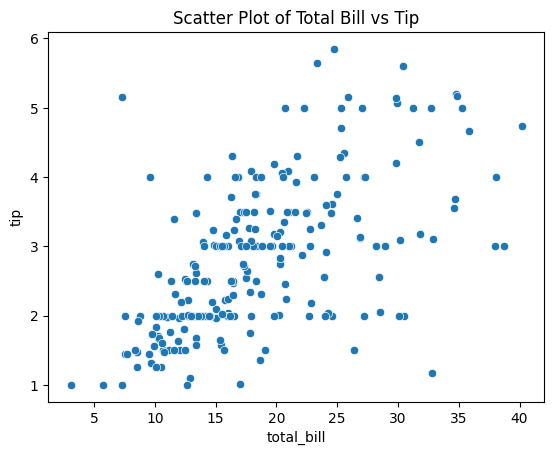

In [106]:
# Scatter Plot
sns.scatterplot(x=data['total_bill'], y=data['tip'])
plt.title('Scatter Plot of Total Bill vs Tip')
plt.show()

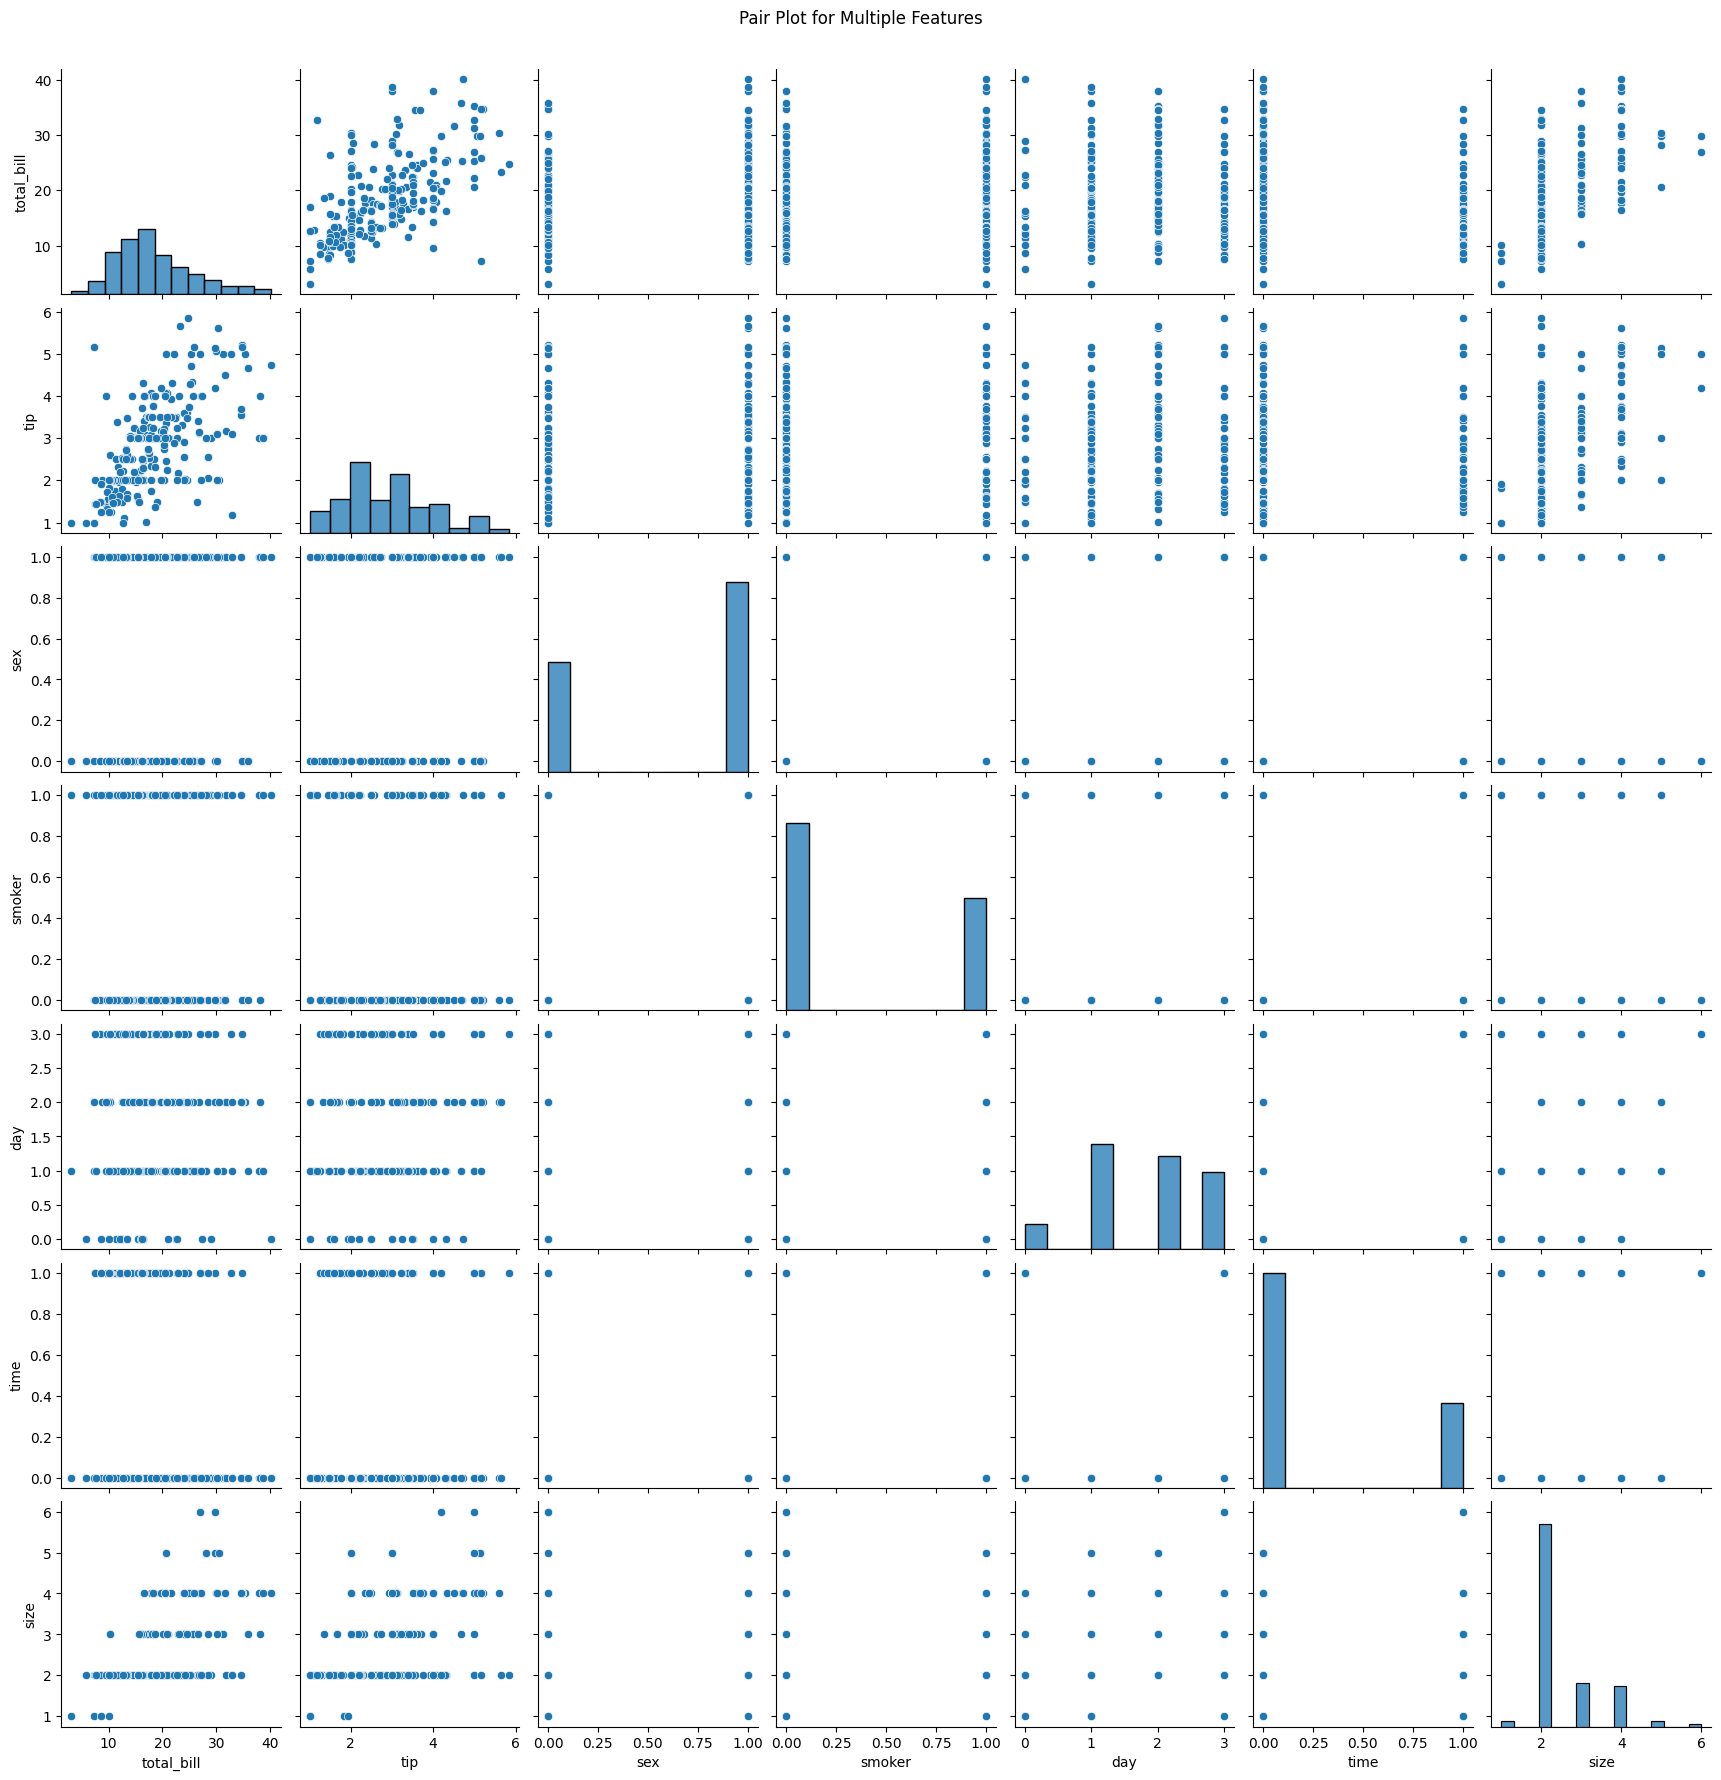

In [107]:
# Pair Plot
sns.pairplot(data)
plt.suptitle("Pair Plot for Multiple Features", y=1.02)
plt.show()

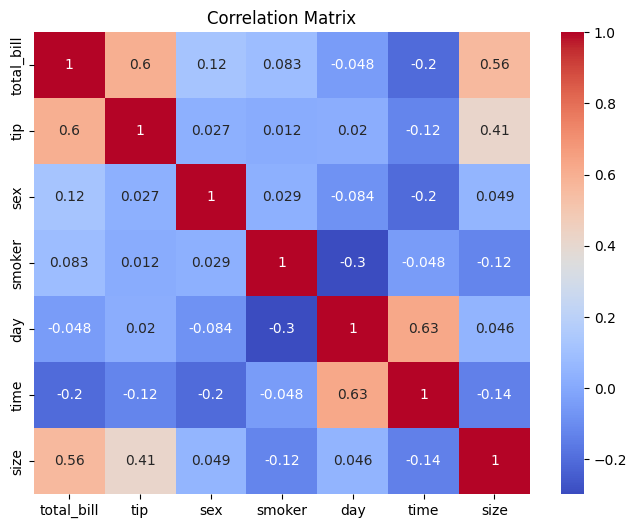

In [108]:
# Correlation Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [109]:
# Rainbow Test for Linearity
import statsmodels.api as sm
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()
rainbow_statistic, rainbow_p_value = linear_rainbow(results)
print(f"Rainbow Test statistic: {rainbow_statistic}, p-value: {rainbow_p_value}")

Rainbow Test statistic: 1.3651622259006178, p-value: 0.0519323536069774


## Scaling the 'total_bill' feature to prepare it for model training

In [110]:
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[['total_bill']] = scaler.fit_transform(X_train[['total_bill']])
X_test_scaled[['total_bill']] = scaler.transform(X_test[['total_bill']])

## Model Training and Evaluation

### Defining the models and parameter grids for hyperparameter tuning

In [111]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Support Vector Regression": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor()
}

param_grids = {
    "Linear Regression": {},
    "Ridge Regression": {
        'alpha': [0.1, 1.0, 10.0]
    },
    "Lasso Regression": {
        'alpha': [0.01, 0.1, 1.0, 10.0]
    },
    "Decision Tree": {
        'max_depth': [3, 5, 7, 10],
        'min_samples_split': [2, 5, 10]
    },
    "Random Forest": {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 10],
        'min_samples_split': [2, 5]
    },
    "Support Vector Regression": {
        'C': [0.1, 1.0, 10.0],
        'epsilon': [0.01, 0.1, 0.5]
    },
    "K-Nearest Neighbors": {
        'n_neighbors': [3, 5, 7, 10],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree']
    }
}

### Functions for:
### 1. Hyperparameter tuning with GridSearchCV
### 2. Evaluating model
### 3. Plotting Residuals

In [112]:
def hyperparameter_tuning(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_


def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, mae, r2


def plot_residuals(model, X_train, X_test, y_train, y_test):
    y_pred = model.predict(X_test)
    
    residuals = y_test - y_pred
    
    plt.figure(figsize=(8, 6))
    sns.residplot(x=y_pred, y=residuals, lowess=True, line_kws={'color': 'red'})
    plt.title("Residual Plot")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.show()

Tuning hyperparameters for Linear Regression...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


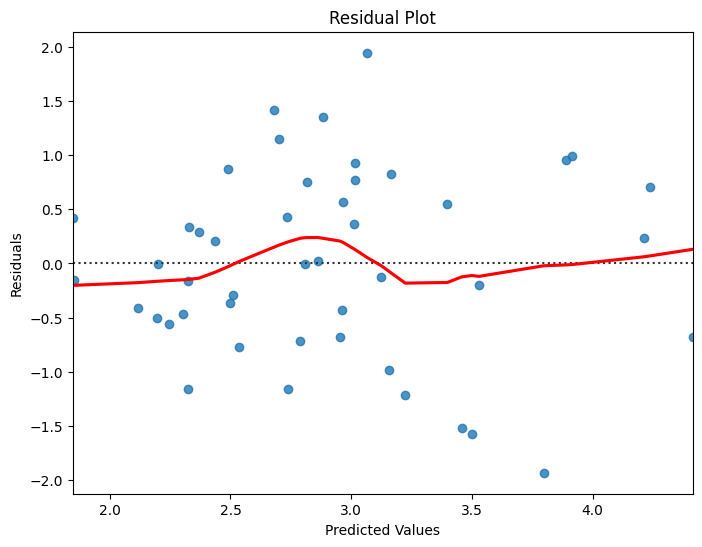

Tuning hyperparameters for Ridge Regression...
Fitting 5 folds for each of 3 candidates, totalling 15 fits


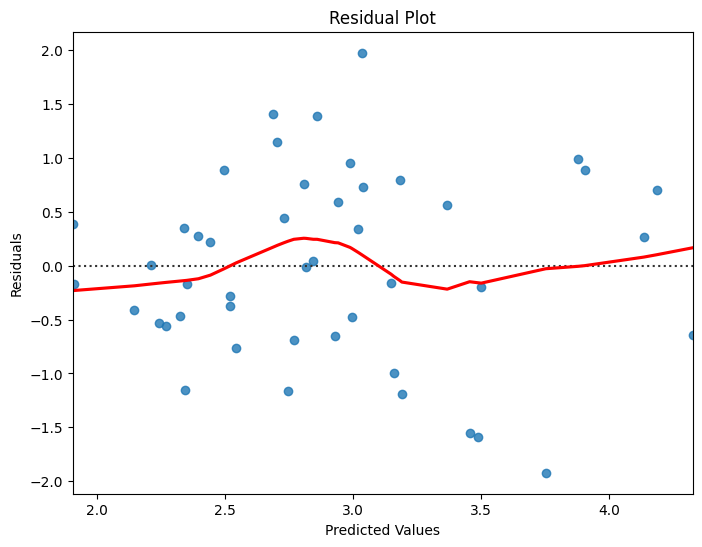

Tuning hyperparameters for Lasso Regression...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


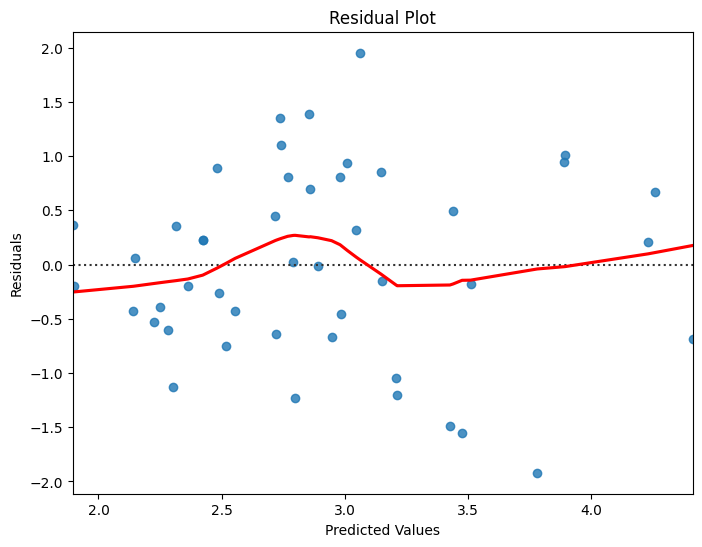

Tuning hyperparameters for Decision Tree...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


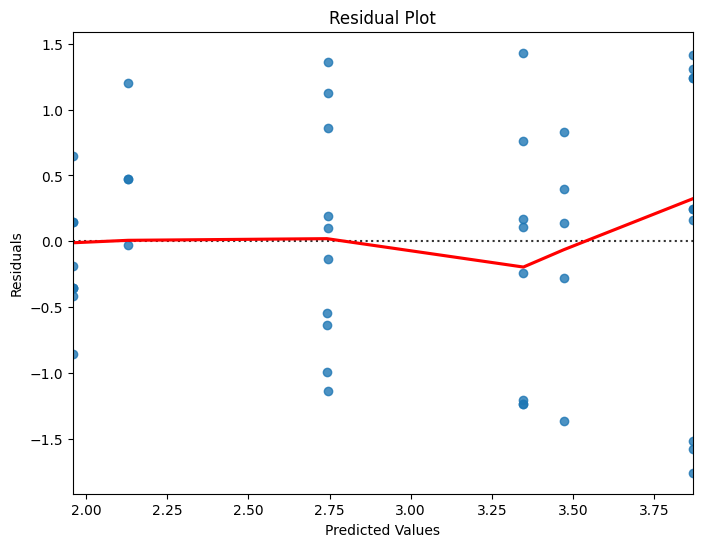

Tuning hyperparameters for Random Forest...
Fitting 5 folds for each of 18 candidates, totalling 90 fits


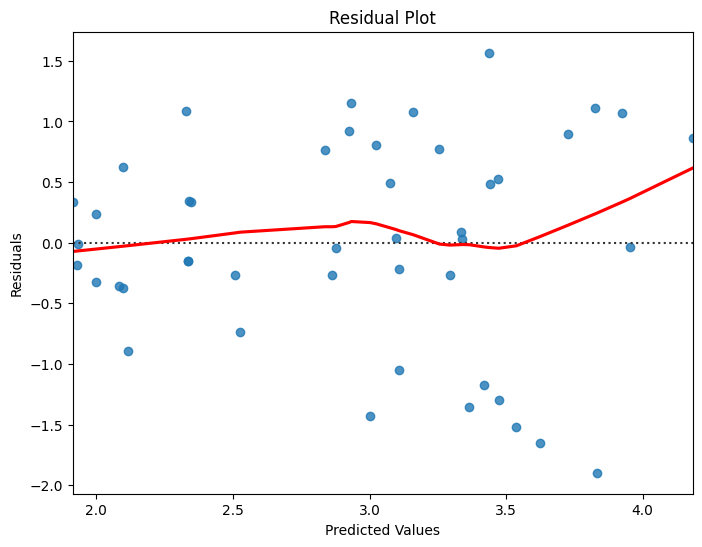

Tuning hyperparameters for Support Vector Regression...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


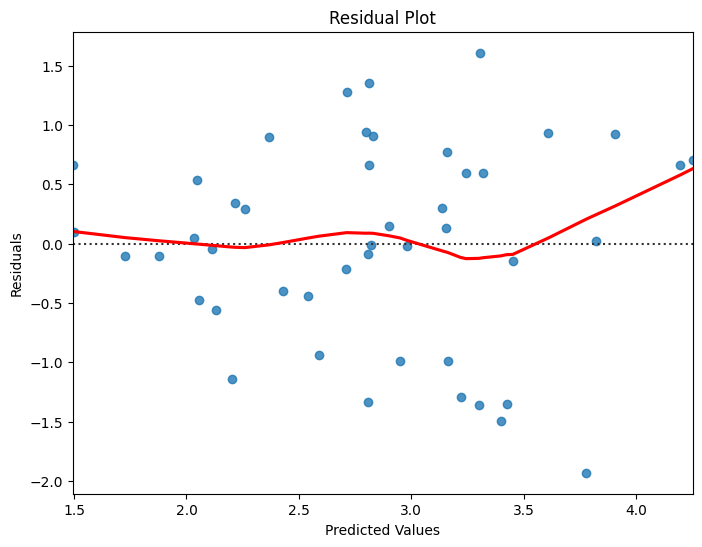

Tuning hyperparameters for K-Nearest Neighbors...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


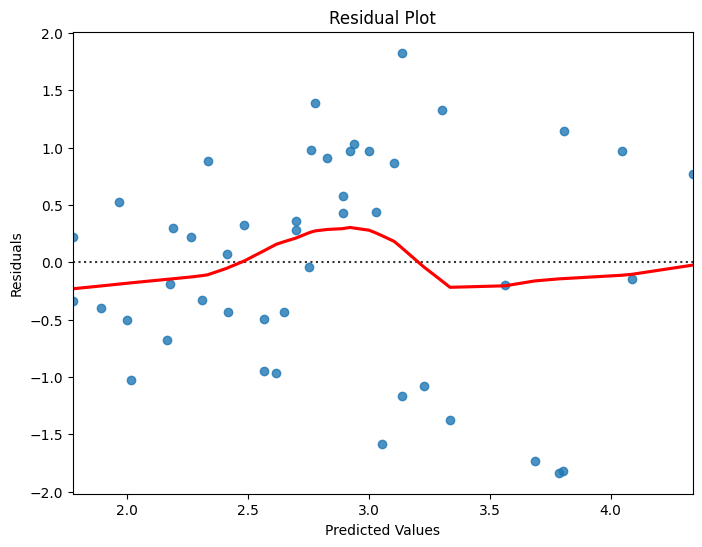

In [113]:
results = {}

for model_name, model in models.items():
    print(f"Tuning hyperparameters for {model_name}...")
    
    best_model, best_params = hyperparameter_tuning(model, param_grids[model_name], X_train_scaled, y_train)
    
    mse, mae, r2 = evaluate_model(best_model, X_train_scaled, X_test_scaled, y_train, y_test)
    results[model_name] = {"Best Parameters": best_params, "MSE": mse, "MAE": mae, "R^2": r2}

    plot_residuals(best_model, X_train_scaled, X_test_scaled, y_train, y_test)

## Displaying the results

In [114]:
for model_name, metrics in results.items():
    print(f"{model_name}:")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value}")

Linear Regression:
  Best Parameters: {}
  MSE: 0.7431976759057437
  MAE: 0.7212486588990413
  R^2: 0.4135091572289469
Ridge Regression:
  Best Parameters: {'alpha': 10.0}
  MSE: 0.7518801623811453
  MAE: 0.7258825422063387
  R^2: 0.4066574151213028
Lasso Regression:
  Best Parameters: {'alpha': 0.01}
  MSE: 0.744663767289933
  MAE: 0.7225844749116022
  R^2: 0.4123521983210161
Decision Tree:
  Best Parameters: {'max_depth': 3, 'min_samples_split': 2}
  MSE: 0.7826536856216123
  MAE: 0.7043716679741585
  R^2: 0.382372638452242
Random Forest:
  Best Parameters: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 200}
  MSE: 0.7360550291357759
  MAE: 0.6997036002793907
  R^2: 0.41914574229849655
Support Vector Regression:
  Best Parameters: {'C': 1.0, 'epsilon': 0.1}
  MSE: 0.7098508007123521
  MAE: 0.6878531378758701
  R^2: 0.4398246821155367
K-Nearest Neighbors:
  Best Parameters: {'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'uniform'}
  MSE: 0.8472398260869565
  MAE: 0.7733

## Insights for Management

1. There is a direct relationship between the total bill and the tip amount. Higher total bills generally result in higher tips. Train servers to focus on providing excellent service for customers with higher bills, as these customers are more likely to tip well.
2. Certain days of the week may see higher total bills and tip amounts. For example, weekends (Friday, Saturday, Sunday) may show higher tips than weekdays. Consider staffing more servers on busier days to ensure high-quality service, especially on days like Sunday, which could have higher foot traffic. Adjust marketing campaigns or promotions for weekends or busy days to maximize revenue during peak periods.
3. Tips may vary significantly between lunch and dinner shifts, with dinner potentially yielding higher tips due to higher total bills. Offer dinner-specific promotions or highlight high-margin items during dinner hours to increase the total bill and tips.